In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : Symmetric Convolution


In [2]:
'''model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))'''

"model = VGG16(weights='imagenet',\n                  include_top=False,\n                  input_shape=(224, 224, 3))"

In [3]:
k = 20 # Top 10% highest l2-magnitude filters

(3, 3, 1, 1)


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.


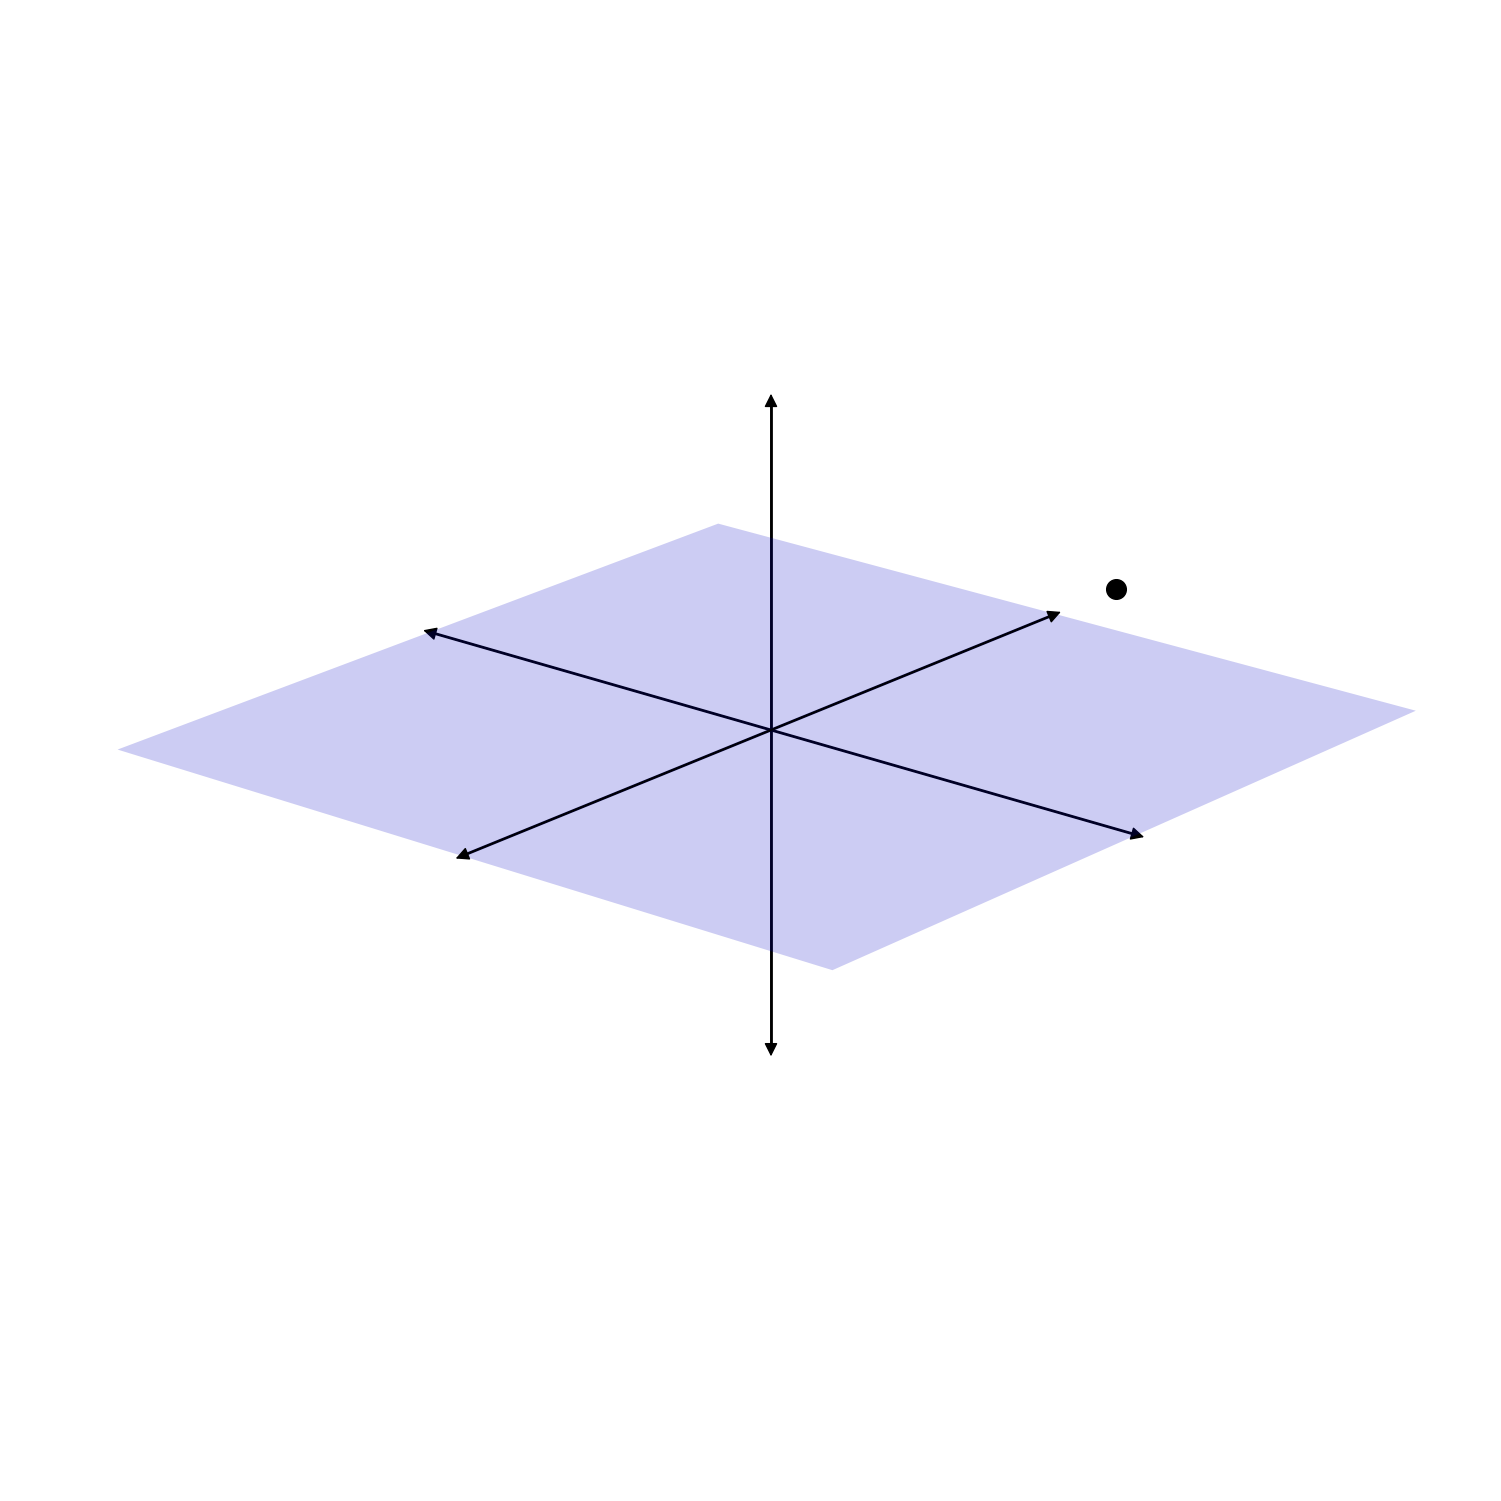

In [4]:
F = 0

filters = np.zeros((3,3,1,1))
filters[:,:,0,0] =  (1/(6))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]])


theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)

a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])


x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y =( a_mag[:,F]*np.sin((theta[:,F]))).numpy()
z =(s_mag[:,F]*np.sign(np.mean(s, axis=(0,1)))[:,F]).numpy()
plt.rcParams.update({'figure.dpi': '100'})


class Arrow3D(FancyArrowPatch):
	def __init__(self, xs, ys, zs, *args, **kwargs):
		super().__init__((0,0), (0,0), *args, **kwargs)
		self._verts3d = xs, ys, zs

	def do_3d_projection(self, renderer=None):
		xs3d, ys3d, zs3d = self._verts3d
		xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, self.axes.M)
		self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
		return np.min(zs)

	def draw(self, renderer):
		xs3d, ys3d, zs3d = self._verts3d
		xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
		self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
		FancyArrowPatch.draw(self, renderer)

# Create a new figure and a 3D axis
fig = plt.figure(figsize=(15, 15),constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Remove the panes (walls)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Remove the pane lines
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')

# Remove grid lines
ax.grid(False)

# Remove default tick marks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Create the axes lines
axis_length = 10
ax.plot([-1, 1], [0, 0], [0, 0], 'k-', linewidth=2)  # x-axis
ax.plot([0, 0], [-1, 1], [0, 0], 'k-', linewidth=2)  # y-axis
ax.plot([0, 0], [0, 0], [-1, 1], 'k-', linewidth=2)  # z-axis

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits for each axis
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

arrow_prop_dict = dict(mutation_scale=20, arrowstyle='<|-|>', shrinkA=0, shrinkB=0)


	
a = Arrow3D([- 1.02, 1.02], [0, 0], [0, 0], **arrow_prop_dict, color='k')
ax.add_artist(a)
a = Arrow3D( [0, 0],[- 1.02, 1.02], [0, 0], **arrow_prop_dict, color='k')
ax.add_artist(a)
a = Arrow3D([0, 0], [0, 0],[-1.02, 1.02], **arrow_prop_dict, color='k')
ax.add_artist(a)


# Color the x,y plane
xx, yy = np.meshgrid(range(-1, 2), range(-1, 2))
ax.plot_surface(xx, yy, np.zeros_like(xx), alpha=0.2, color='blue') 
# Add text to the x,y plane
#ax.text(0, 0, 0, "X-Y Plane", fontsize=14, ha='center', va='center', 
#        zdir='x', zorder=20)# Example: Plot some 3D points
points = np.array([x,y,z]).T*3
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='k', s=200)
plt.axis('off')
# Show the plot

ax.view_init(elev=20, azim=40)

#fig.savefig(f'hand_antisym_unipolar.pdf', dpi=600,  transparent=True, bbox_inches='tight')
plt.show()

#import subprocess
#subprocess.run(["pdfcrop ", f'hand_antisym_unipolar.pdf']) 


In [6]:
img.shape

(224, 224)

(45, 45)


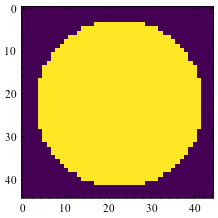

In [12]:
#var = 2/(128*9)

N = 45
img =  tf.expand_dims(cv2.imread('input4.png', 0)/255. , axis=-1)
H, W, C = img.shape  # Get image dimensions
offset_height = (H - N) // 2
offset_width = (W - N) // 2
img = tf.image.crop_to_bounding_box(img, offset_height, offset_width, N, N)[...,0]
plt.imshow(img)
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)

In [6]:
img[120,127]

1.0

In [7]:
x.shape

(1,)

0
(1, 45, 45, 1)
0.4197467
1
(1, 45, 45, 1)
0.41904598
2
(1, 45, 45, 1)
0.4169481
3
(1, 45, 45, 1)
0.41346598
4
(1, 45, 45, 1)
0.4086211
5
(1, 45, 45, 1)
0.40244994
6
(1, 45, 45, 1)
0.39499578
7
(1, 45, 45, 1)
0.38630816
8
(1, 45, 45, 1)
0.3764468
9
(1, 45, 45, 1)
0.36548215
10
(1, 45, 45, 1)
0.35349908
11
(1, 45, 45, 1)
0.34059954
12
(1, 45, 45, 1)
0.32689568
13
(1, 45, 45, 1)
0.3125229
14
(1, 45, 45, 1)
0.2976549
15
(1, 45, 45, 1)
0.28247428
16
(1, 45, 45, 1)
0.26720014
17
(1, 45, 45, 1)
0.25212717
18
(1, 45, 45, 1)
0.2375648
19
(1, 45, 45, 1)
0.22386076
20


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(1, 45, 45, 1)
0.21143304
21
(1, 45, 45, 1)
0.20077087
22
(1, 45, 45, 1)
0.19230808
23
(1, 45, 45, 1)
0.18646258
24
(1, 45, 45, 1)
0.18362829
25
(1, 45, 45, 1)
0.18401079
26
(1, 45, 45, 1)
0.18748856
27
(1, 45, 45, 1)
0.19380678
28
(1, 45, 45, 1)
0.2026551
29
(1, 45, 45, 1)
0.21358769
30
(1, 45, 45, 1)
0.2261116
31
(1, 45, 45, 1)
0.2397799
32
(1, 45, 45, 1)
0.2542395
33
(1, 45, 45, 1)
0.269144
34
(1, 45, 45, 1)
0.28419834
35
(1, 45, 45, 1)
0.29917976
36
(1, 45, 45, 1)
0.31389874
37
(1, 45, 45, 1)
0.3281695
38
(1, 45, 45, 1)
0.34184253
39
(1, 45, 45, 1)
0.35479474
40
(1, 45, 45, 1)
0.36690488
41
(1, 45, 45, 1)
0.3780701
42
(1, 45, 45, 1)
0.38820475
43
(1, 45, 45, 1)
0.39723065
44
(1, 45, 45, 1)
0.40508103
45
(1, 45, 45, 1)
0.41170013
46
(1, 45, 45, 1)
0.41704288
47
(1, 45, 45, 1)
0.42107987
48
(1, 45, 45, 1)
0.42378607
49
(1, 45, 45, 1)
0.42514363
50
(1, 45, 45, 1)
0.42514363
51
(1, 45, 45, 1)
0.4237861
52
(1, 45, 45, 1)
0.42107987
53
(1, 45, 45, 1)
0.41704288
54
(1, 45, 45, 1)
0.411700

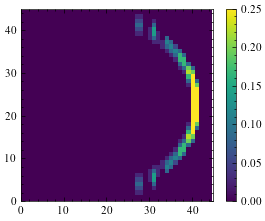

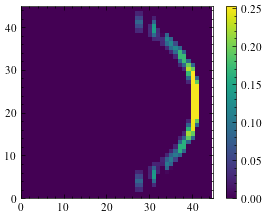

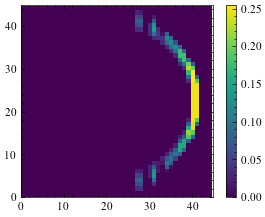

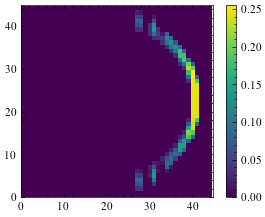

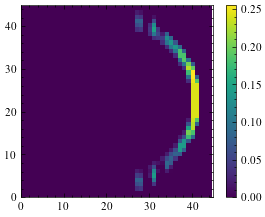

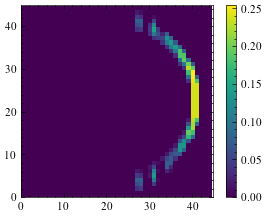

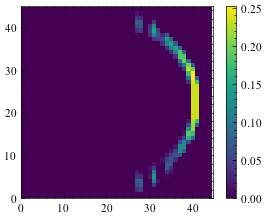

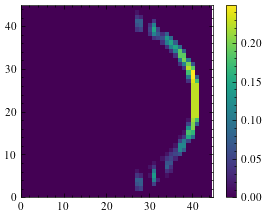

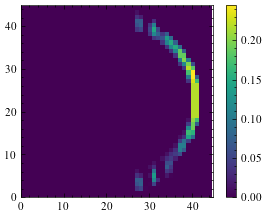

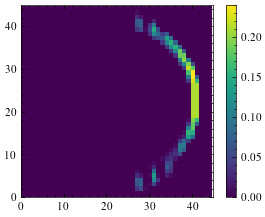

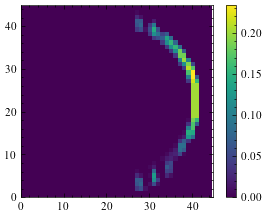

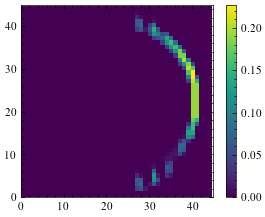

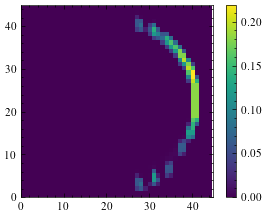

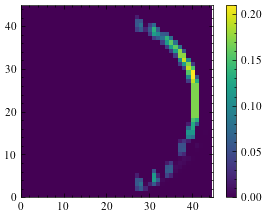

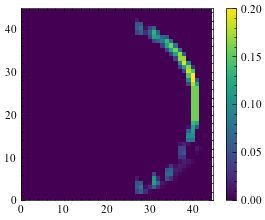

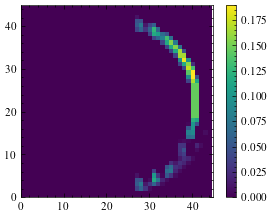

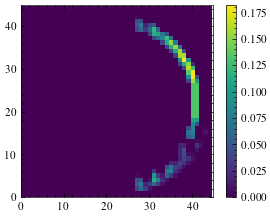

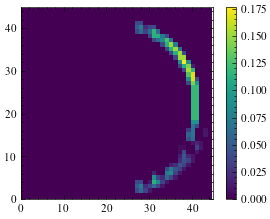

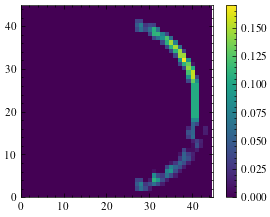

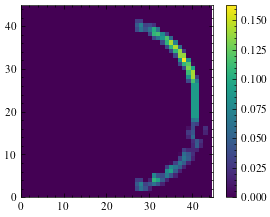

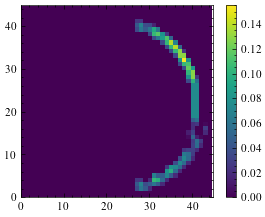

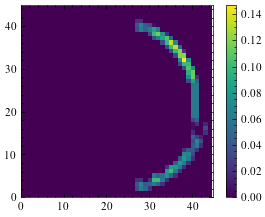

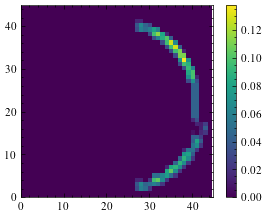

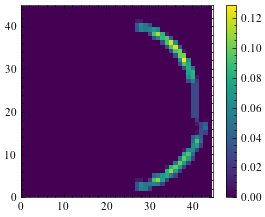

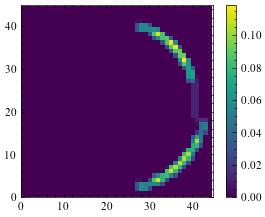

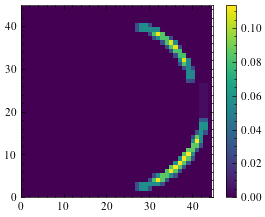

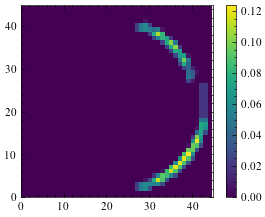

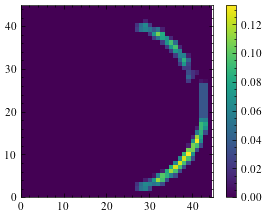

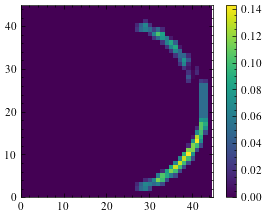

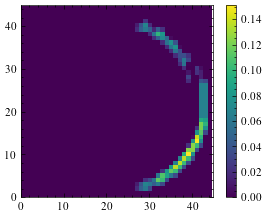

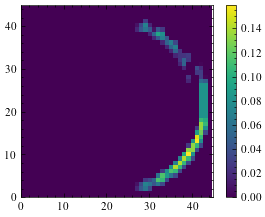

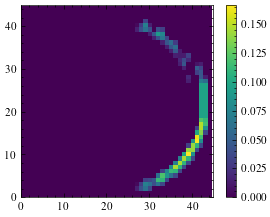

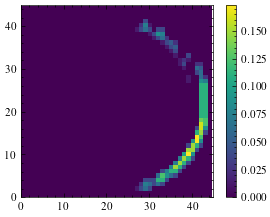

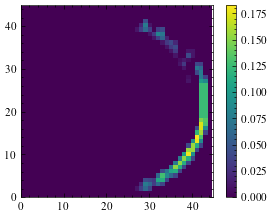

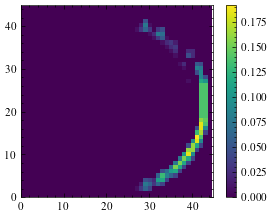

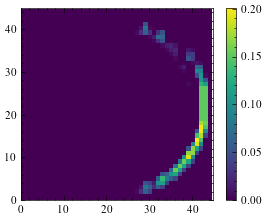

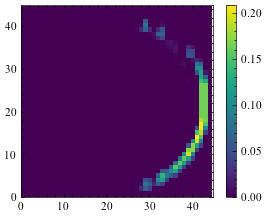

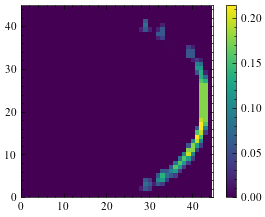

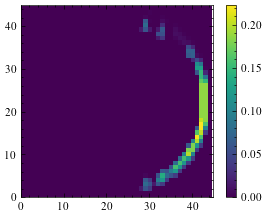

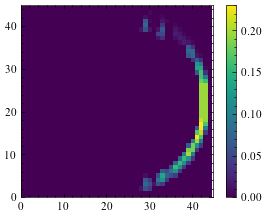

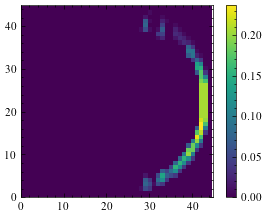

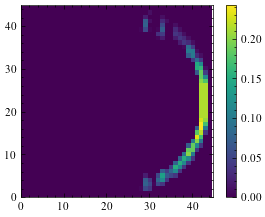

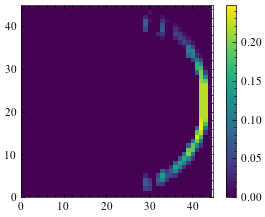

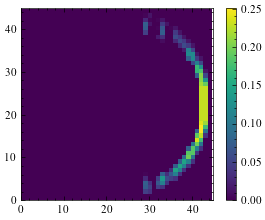

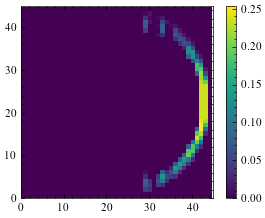

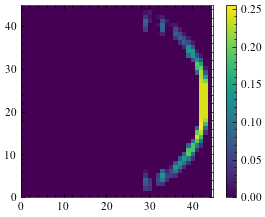

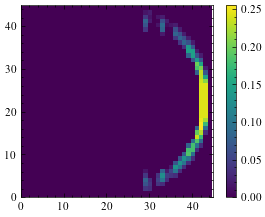

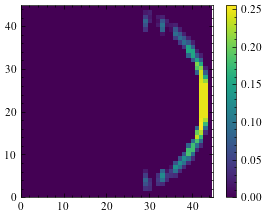

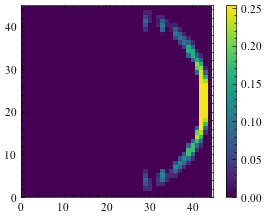

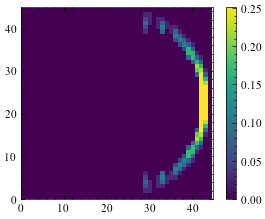

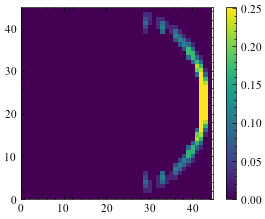

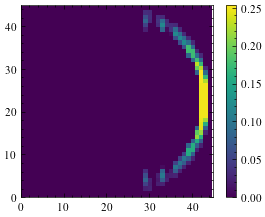

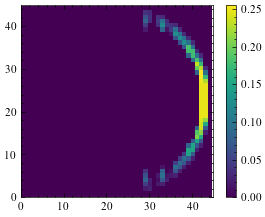

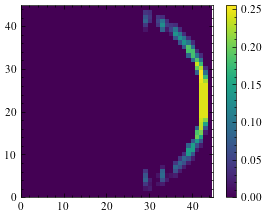

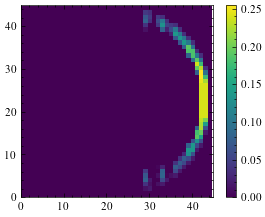

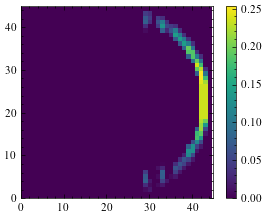

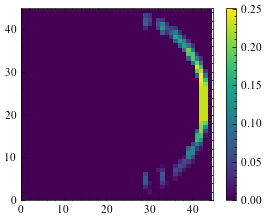

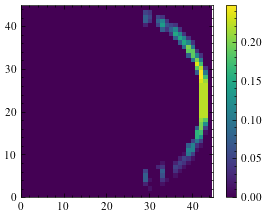

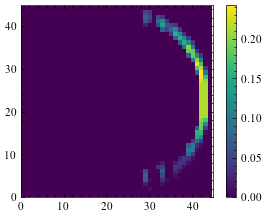

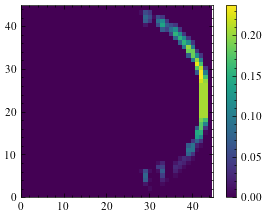

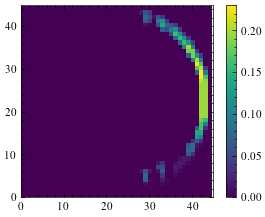

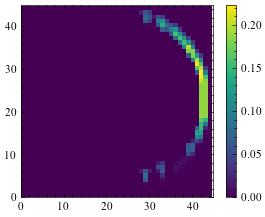

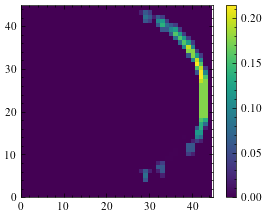

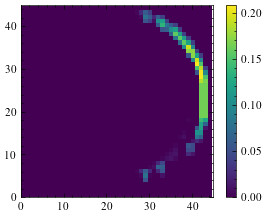

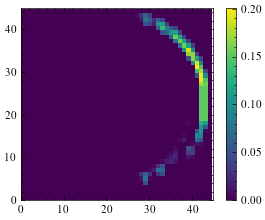

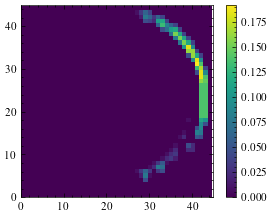

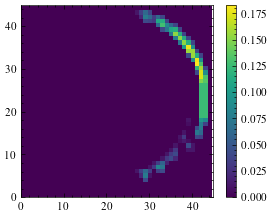

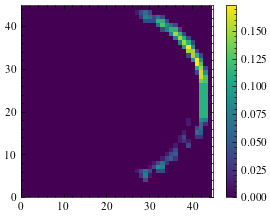

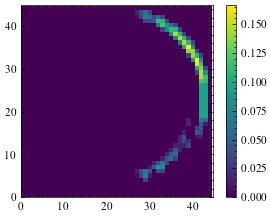

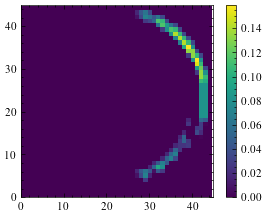

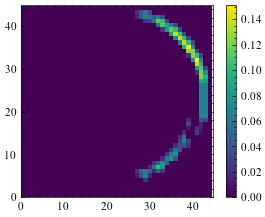

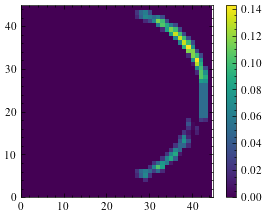

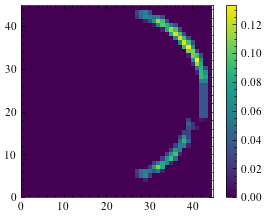

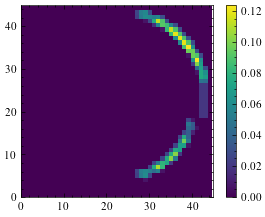

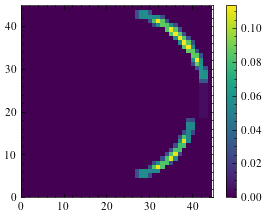

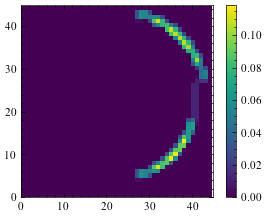

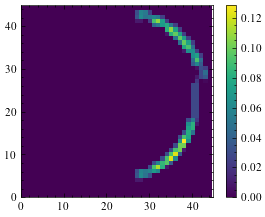

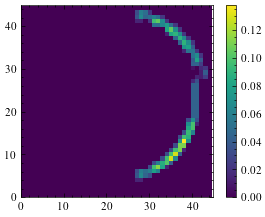

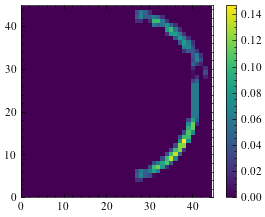

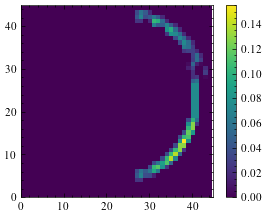

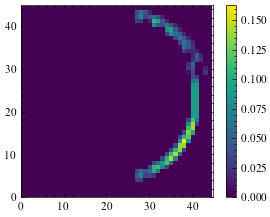

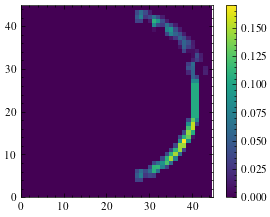

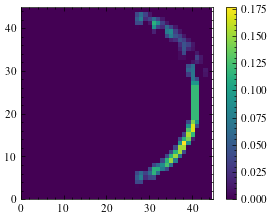

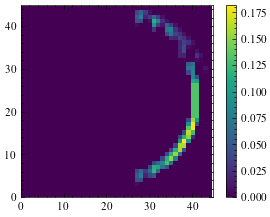

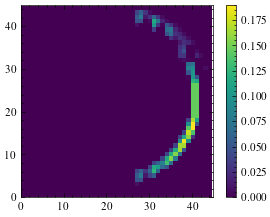

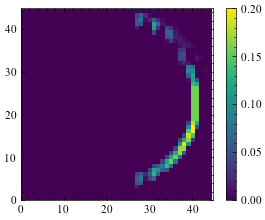

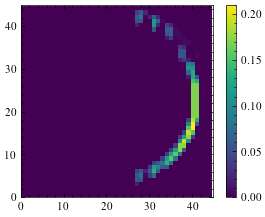

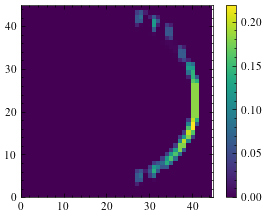

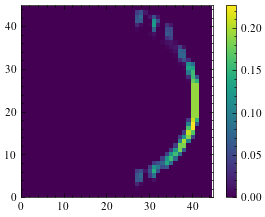

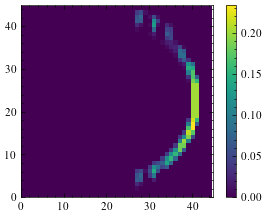

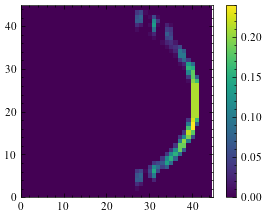

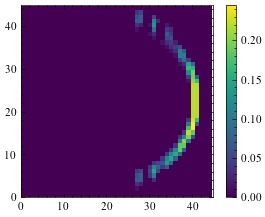

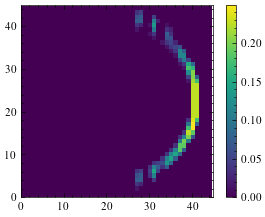

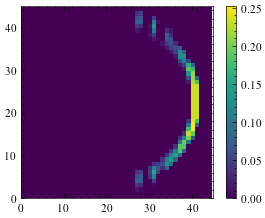

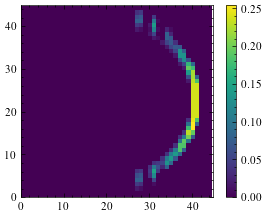

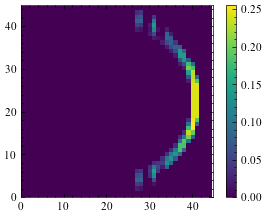

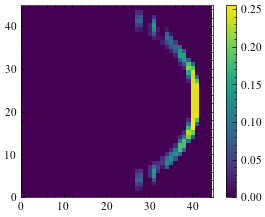

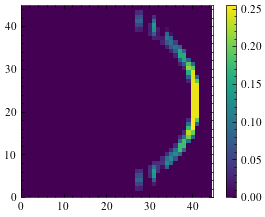

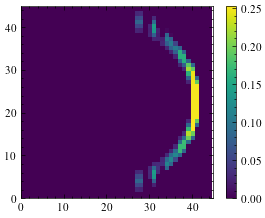

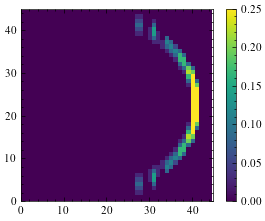

In [16]:
import matplotlib.patches as mpatches


w = np.zeros((3,3,1,1))
w[:,:,0,0] = (1/(6))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]])


x = img




directory = f"figures/malus"
if not os.path.exists(directory):
	os.makedirs(directory)


response_mag = []
init_mag = tf.math.reduce_euclidean_norm(x).numpy()

x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 


x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							 padding='SAME') )

init_mag = tf.math.reduce_euclidean_norm(x).numpy()

angles = np.linspace(-np.pi, np.pi, 100)
for i in range(100):
	print(i)
	fig, ax = plt.subplots()
	print(x.shape)
	
	
	w[:,:,0,0] = (np.cos(angles[i]))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angles[i]))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
	w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w[:,:,0,0])**2)

		
	x_out = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
								padding='SAME') )

	response_mag.append(tf.math.reduce_euclidean_norm(x_out).numpy()/init_mag)
	print(response_mag[-1])

	im = ax.imshow(np.sum(x_out[0,:,:,:], axis=-1));
	#ax.plot(45//2, 45, marker = '+', color='red');



	ax.set(xlim=(0, 45), ylim=(0, 45));

	fig.colorbar(im, orientation='vertical');
	fig.savefig(directory + f'/{i}.pdf', dpi=600,  transparent=True, bbox_inches='tight')




In [31]:
i=0
(np.cos(angles[i]))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angles[i]))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])

array([[-1.0000000e+00, -1.2246468e-16,  1.0000000e+00],
       [-1.0000000e+00, -0.0000000e+00,  1.0000000e+00],
       [-1.0000000e+00,  1.2246468e-16,  1.0000000e+00]])

In [34]:
angles

array([-3.14159265, -3.07812614, -3.01465962, -2.9511931 , -2.88772658,
       -2.82426006, -2.76079354, -2.69732703, -2.63386051, -2.57039399,
       -2.50692747, -2.44346095, -2.37999443, -2.31652792, -2.2530614 ,
       -2.18959488, -2.12612836, -2.06266184, -1.99919533, -1.93572881,
       -1.87226229, -1.80879577, -1.74532925, -1.68186273, -1.61839622,
       -1.5549297 , -1.49146318, -1.42799666, -1.36453014, -1.30106362,
       -1.23759711, -1.17413059, -1.11066407, -1.04719755, -0.98373103,
       -0.92026451, -0.856798  , -0.79333148, -0.72986496, -0.66639844,
       -0.60293192, -0.53946541, -0.47599889, -0.41253237, -0.34906585,
       -0.28559933, -0.22213281, -0.1586663 , -0.09519978, -0.03173326,
        0.03173326,  0.09519978,  0.1586663 ,  0.22213281,  0.28559933,
        0.34906585,  0.41253237,  0.47599889,  0.53946541,  0.60293192,
        0.66639844,  0.72986496,  0.79333148,  0.856798  ,  0.92026451,
        0.98373103,  1.04719755,  1.11066407,  1.17413059,  1.23

In [19]:
w[:,:,0,0]

array([[-0.43331906, -0.02589271,  0.38153365],
       [-0.40742635, -0.        ,  0.40742635],
       [-0.38153365,  0.02589271,  0.43331906]])

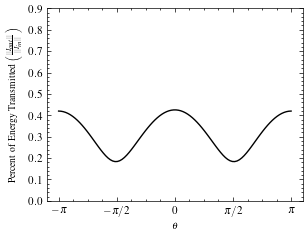

In [15]:
fig, ax= plt.subplots(1,1)

ax.plot(angles,response_mag)

ticks = np.arange(-np.pi, 1.5*np.pi, np.pi/2)
labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels);
ax.set_yticks(ticks=np.arange(0,1, 0.1));

ax.set_ylabel(r"Percent of Energy Transmitted $\left( \frac{||I_{out}||}{||I_{in}||} \right)$", fontsize=7)
ax.set_xlabel(r"$\theta$", fontsize=7)

plt.savefig('figures/malus.pdf', dpi=600)
plt.show()


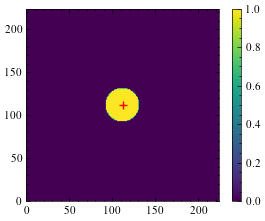

In [74]:
fig, ax= plt.subplots(1,1)


im = ax.imshow(img)
ax.plot(112, 112, marker = '+', color='red')



ax.set(xlim=(0, 224), ylim=(0, 224))

fig.colorbar(im, orientation='vertical')
fig.savefig(directory + f'/original.pdf', dpi=600,  transparent=True, bbox_inches='tight')


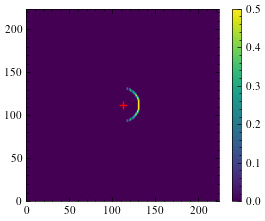

In [77]:
fig, ax= plt.subplots(1,1)


x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 

w = np.zeros((3,3,1,1))
w[:,:,0,0] = (1/(6))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]])

x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							 padding='SAME') )

im = ax.imshow(x[0,:,:,0])
ax.plot(112, 112, marker = '+', color='red')



ax.set(xlim=(0, 224), ylim=(0, 224))

fig.colorbar(im, orientation='vertical')
fig.savefig(directory + f'/reference.pdf', dpi=600,  transparent=True, bbox_inches='tight')

In [76]:
x

<tf.Tensor: shape=(1, 224, 224, 1), dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]], dtype=float32)>